In [53]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

In [54]:
import matplotsoccer
import socceraction.spadl as spadl

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

def plot_buildup(goal_id, df_actions, team_name, c_string):
    df = df_actions[goal_id-5:goal_id+1].copy()
    df = df.reset_index(drop=True)
    opponent_df = df[df['team_name'] != df['team_name'].iloc[len(df)-1]]
    if opponent_df.empty:
        last_row = 0
    else:
        last_row = opponent_df.index[-1]+1

    df = df[last_row:]

    df["nice_time"] = df.apply(nice_time, axis=1)
    labels = df[["nice_time", "type_name", "player_name", "team_name"]]
    
    print(c_string)

    ax = matplotsoccer.actions(
        location=df[["start_x", "start_y", "end_x", "end_y"]],
        action_type=df.type_name,
        team= df.team_name,
        result= df.result_name == "success",
        label=labels,
        labeltitle=["time", "actiontype", "player", "team"],
        zoom=False,
        figsize=6
    )

def find_goal(df, team_id):
    df = df[df['type_id'] == 11]
    df = df[df['result_id'] == 1]
    df = df[df['team_id'] == team_id]
    return df.index


[Switzerland] vs Cameroon (FIFA World Cup Group Stage - 2022)


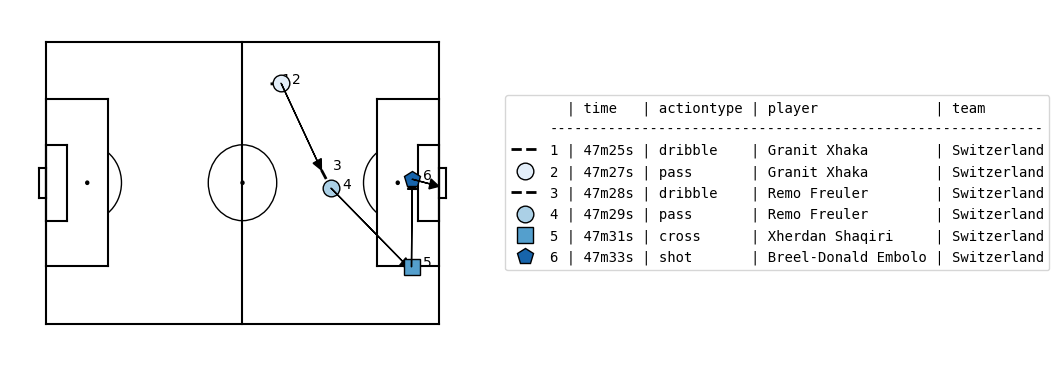

In [55]:
import random

loop = True

while loop:

    loop = False

    df_competitions = api.competitions()
    random_row = df_competitions.sample(1)
    c_id = random_row['competition_id'].iloc[0]
    s_id = random_row['season_id'].iloc[0]
    c_name = random_row['competition_name'].iloc[0]
    s_name = random_row['season_name'].iloc[0]

    df_games = api.games(competition_id=c_id, season_id=s_id)
    
    all_teams = list(df_games['home_team_id'].unique())
    team_id = random.choice(all_teams)

    df_games = df_games[(df_games['away_team_id'] == team_id) | (df_games['home_team_id'] == team_id)]
    all_games = list(df_games['game_id'])

    g = random.choice(all_games)
    c_stage = df_games[df_games['game_id'] == g]['competition_stage'].iloc[0]
    df_teams = api.teams(game_id=g)
    df_players = api.players(game_id=g)
    df_events = api.events(game_id=g)
    team_name = df_events[df_events['team_id'] == team_id]['team_name'].iloc[0]
    teams = list(df_events['team_name'].unique())
    teams.remove(team_name)

    df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
    df_actions = (
    spadl
    .add_names(df_actions)
    .merge(api.teams(game_id=g))
    .merge(api.players(game_id=g))
    )
    df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True]).reset_index(drop=True)

    c_string = f"[{team_name}] vs {teams[0]} ({c_name} {c_stage} - {s_name})"
    c_string_no_goal = f"{team_name} vs {teams[0]} ({c_name} {c_stage} - {s_name})"

    goals = list(find_goal(df_actions, team_id))

    if goals:
        i = random.choice(goals)
        plot_buildup(i, df_actions, team_name, c_string)
    else:
        print(f"No goals were scored in {c_string_no_goal}")
        loop = True